# SeaFlow data (regridded)

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    5:'data/SeaFlow_SizeDist_regrid-15-5.nc',
    8:'data/SeaFlow_SizeDist_regrid-25-8.nc',
    10:'data/SeaFlow_SizeDist_regrid-35-10.nc',
    19:'data/SeaFlow_SizeDist_regrid-60-19.nc',
}

data_seaflow = {}
for k in datafiles:
    data_seaflow[k] = {}
    with nc4.Dataset(datafiles[k]) as nc:
        for var in nc.variables:
            data_seaflow[k][var] = nc.variables[var][:]

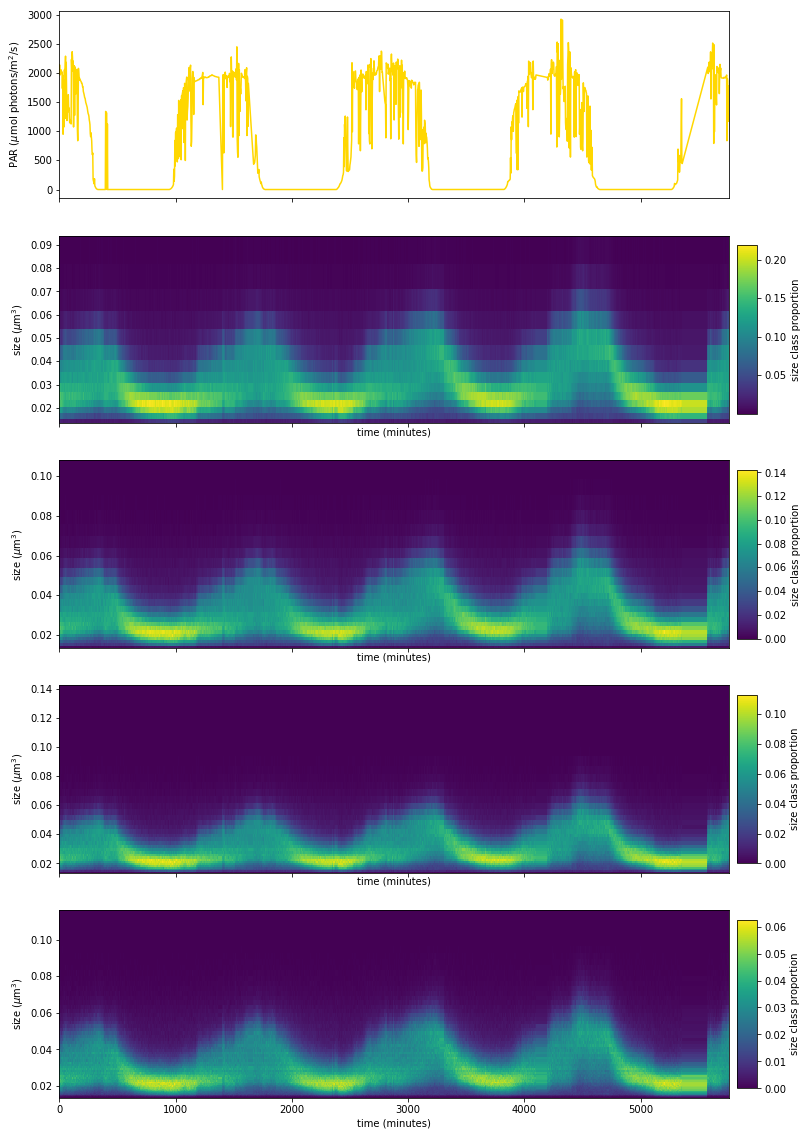

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

nrows = 1+len(datafiles)
fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

ax = axs[0]
ax.plot(data_seaflow[5]['time'], data_seaflow[5]['PAR'], color='gold')
ax.set(ylabel='PAR ($\mu$mol photons/m$^{2}$/s)')

for ax,k in zip(axs[1:], data_seaflow):
    v_min = data_seaflow[k]['v_min']
    delta_v = 1.0/data_seaflow[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v) 
    pc = ax.pcolormesh(data_seaflow[k]['time'],v,data_seaflow[k]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)', xlabel='time (minutes)')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
None

# The model

modified from *Sosik et al. (2003), Growth rates of coastal phytoplankton from time-series measurements with a submersible flow cytometer, Limnol. Oceanogr.*

In [7]:
# prepare data for Stan model

data = {}

for k in data_seaflow:
    if k < 10:
        dt = 20 # in units of minutes
    else:
        dt = 10 # in units of minutes

    data[k] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[k][v] = data_seaflow[k][v]

    data[k]['obs'] = data_seaflow[k]['w_obs']
    data[k]['t_obs'] = data_seaflow[k]['time']
    data[k]['E'] = data_seaflow[k]['PAR']
    # use first measurements as initial conditions
    data[k]['w_ini'] = data_seaflow[k]['w_obs'][:,0]

    # limit the data

    limit_days = 2
    stride_t_obs = 20

    # remove very first observations
    ind_obs = data[k]['t_obs'] > 3
    data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
    data[k]['obs'] = data[k]['obs'][:,ind_obs]

    if limit_days > 0:
        limit_minutes = limit_days*1440

        ind_obs = data[k]['t_obs'] < limit_minutes
        data[k]['t_obs'] = data[k]['t_obs'][ind_obs]
        data[k]['obs'] = data[k]['obs'][:,ind_obs]

        data[k]['nt'] = int(limit_minutes//data[k]['dt'])

    if stride_t_obs > 0:
        data[k]['t_obs'] = data[k]['t_obs'][::stride_t_obs]
        data[k]['obs'] = data[k]['obs'][:,::stride_t_obs]

    data[k]['nt_obs'] = data[k]['obs'].shape[1]

    # finally, add light data
    t = np.arange(data[k]['nt'])*data[k]['dt']
    data[k]['E'] = np.interp(t, xp=data_seaflow[k]['time'], fp=data_seaflow[k]['PAR'])

In [9]:
import pystan

modelfiles = {
    'oldformulation':'stancode/matrixmodel_sigmoidaldelta.stan',
    'normparam':'stancode/matrixmodel_sigmoidaldelta_normparam.stan',
}

models = {name:pystan.StanModel(file=modelfiles[name], model_name=name, obfuscate_model_name=False) for name in modelfiles}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL oldformulation NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL normparam NOW.


In [11]:
# run a bunch of experiments -- this may take a while

mcmc = {}
for name in models:
    mcmc[name] = {}
    for k in data:
        mcmc[name][k] = models[name].sampling(data=data[k], iter=2000)
        print('model: "{}", delta_v_inv={}'.format(name, k))
        print('\n'.join(x for x in mcmc[name][k].__str__().split('\n') if 'mod_obspos' not in x))

model: "oldformulation", delta_v_inv=5
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max            3.8    0.03   0.76   2.67   3.28   3.68   4.18   5.69    823    1.0
gamma_max          28.22    0.06   2.44  23.33  26.65  28.25  29.79  32.88   1613    1.0
sig_offset          0.03  8.5e-5 2.5e-3   0.03   0.03   0.03   0.04   0.04    851    1.0
sig_steepness     238.04    1.89  70.26 126.96 188.19 228.65 277.39 403.88   1381    1.0
E_star            3000.0     0.2  10.26 2980.1 2993.0 3000.0 3006.8 3020.6   2543    1.0
sigma               0.12  1.4e-4 6.4e-3    0.1   0.11   0.11   0.12   0.13   2033    1.0
lp__              -135.5    0.05   1.84 -139.8 -136.5 -135.1 -134.1 -132.9   1356    1.0

Samples were drawn using NUTS at Mon Jan 27 09:29:15 2020.
For each parameter, n_eff is 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=8
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.63    0.02   0.69   2.59   3.17   3.53   3.98   5.26    800    1.0
gamma_max           45.4    0.09   4.22  37.18  42.51  45.42  48.26  53.76   2277    1.0
sig_offset          0.04  9.4e-5 2.5e-3   0.03   0.03   0.03   0.04   0.04    700    1.0
sig_steepness     222.15    1.81  61.45 120.49  179.8 213.88 258.01  367.7   1155    1.0
E_star            3000.1     0.2    9.9 2980.9 2993.4 3000.0 3006.9 3019.8   2554    1.0
sigma               0.12  1.2e-4 6.5e-3   0.11   0.11   0.12   0.12   0.13   2716    1.0
lp__              -140.1    0.05   1.82 -144.6 -141.1 -139.8 -138.8 -137.6   1237    1.0

Samples were drawn using NUTS at Mon Jan 27 09:32:08 2020.
For each parameter, n_eff is 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=10
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.51    0.02   0.73   2.43   3.01   3.39   3.86   5.33   1059    1.0
gamma_max           54.5    0.11   5.29  44.19  50.94  54.49   58.0  64.78   2384    1.0
sig_offset          0.04  8.7e-5 2.7e-3   0.03   0.03   0.04   0.04   0.04    938    1.0
sig_steepness     218.63    1.75  66.27 117.44 171.65 209.29 255.87 374.67   1429    1.0
E_star            3000.1    0.18  10.05 2980.7 2993.4 3000.1 3007.0 3019.6   3276    1.0
sigma               0.12  1.1e-4 6.5e-3   0.11   0.12   0.12   0.13   0.13   3246    1.0
lp__              -143.8    0.05   1.82 -148.2 -144.8 -143.5 -142.5 -141.3   1351    1.0

Samples were drawn using NUTS at Mon Jan 27 09:40:07 2020.
For each parameter, n_eff is

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "oldformulation", delta_v_inv=19
Inference for Stan model: oldformulation.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.03    0.02   0.59   2.14   2.63   2.95   3.32   4.43   1023    1.0
gamma_max          99.15    0.22  10.41  80.36  91.92  98.37 105.78 121.91   2318    1.0
sig_offset          0.03  8.2e-5 2.3e-3   0.03   0.03   0.03   0.04   0.04    781    1.0
sig_steepness      238.3    1.93  72.07 123.71 187.66 229.59 279.58 406.27   1398    1.0
E_star            3000.0    0.17  10.01 2980.1 2993.3 3000.1 3006.8 3019.1   3450    1.0
sigma               0.12  1.2e-4 6.7e-3   0.11   0.12   0.12   0.13   0.14   2962    1.0
lp__              -149.0    0.05    1.8 -153.4 -150.0 -148.7 -147.7 -146.5   1155   1.01

Samples were drawn using NUTS at Mon Jan 27 09:52:45 2020.
For each parameter, n_eff is

model: "normparam", delta_v_inv=5
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.81    0.03   0.75   2.65   3.31   3.69   4.17   5.66    879    1.0
gamma_max            4.2  7.9e-3   0.36   3.51   3.96    4.2   4.45   4.88   2052    1.0
sig_offset          0.03  8.5e-5 2.4e-3   0.03   0.03   0.03   0.04   0.04    804    1.0
sig_steepness     236.99    2.02  70.13 127.17 186.32  227.4 276.67 398.22   1205    1.0
E_star            3000.0    0.18   9.91 2981.1 2993.2 2999.9 3006.8 3019.1   2900    1.0
sigma               0.12  1.3e-4 6.1e-3    0.1   0.11   0.11   0.12   0.13   2244    1.0
lp__              -137.3    0.05   1.77 -141.6 -138.3 -137.0 -136.0 -134.9   1342    1.0

Samples were drawn using NUTS at Mon Jan 27 09:55:14 2020.
For each parameter, n_eff is a crude me

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=8
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max            3.6    0.02   0.66    2.6   3.16   3.51   3.93   5.12    975    1.0
gamma_max           4.11  7.4e-3   0.37    3.4   3.86   4.11   4.37   4.81   2507    1.0
sig_offset          0.04  7.8e-5 2.3e-3   0.03   0.03   0.03   0.04   0.04    906    1.0
sig_steepness     224.48    1.58  61.03 126.79 182.58 217.55 258.81 367.34   1490    1.0
E_star            3000.1    0.17   10.2 2979.9 2993.3 3000.1 3007.2 3020.5   3421    1.0
sigma               0.12  1.2e-4 6.3e-3   0.11   0.11   0.12   0.12   0.13   2649    1.0
lp__              -142.4    0.05    1.8 -146.9 -143.4 -142.1 -141.2 -140.0   1544    1.0

Samples were drawn using NUTS at Mon Jan 27 09:57:50 2020.
For each parameter, n_eff is a crude me

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=10
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.51    0.02   0.72   2.42   3.01    3.4   3.86   5.22    981    1.0
gamma_max           3.92  8.4e-3   0.38   3.14   3.67   3.93   4.18   4.65   2022    1.0
sig_offset          0.04  8.7e-5 2.7e-3   0.03   0.03   0.04   0.04   0.04    943    1.0
sig_steepness     219.99    1.86  67.65 114.67 172.33 210.83 256.39 382.63   1318    1.0
E_star            2999.9    0.18  10.08 2980.3 2993.1 2999.9 3006.7 3019.2   3236    1.0
sigma               0.12  1.3e-4 6.3e-3   0.11   0.12   0.12   0.13   0.13   2306    1.0
lp__              -146.4    0.05   1.75 -150.6 -147.3 -146.0 -145.0 -143.9   1403    1.0

Samples were drawn using NUTS at Mon Jan 27 10:06:17 2020.
For each parameter, n_eff is a crude m

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


model: "normparam", delta_v_inv=19
Inference for Stan model: normparam.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max           3.03    0.02   0.59   2.14   2.64   2.93   3.33   4.44   1452    1.0
gamma_max           3.68  8.7e-3    0.4   2.98   3.41   3.67   3.93   4.54   2078    1.0
sig_offset          0.03  6.0e-5 2.2e-3   0.03   0.03   0.03   0.04   0.04   1347    1.0
sig_steepness     234.94    1.54  72.26 122.25  184.1 226.19 274.09 402.65   2190    1.0
E_star            3000.0    0.17   9.91 2980.3 2993.3 2999.9 3006.6 3019.9   3366    1.0
sigma               0.12  1.2e-4 6.6e-3   0.11   0.12   0.12   0.13   0.14   3230    1.0
lp__              -152.4    0.05   1.83 -156.9 -153.3 -152.0 -151.0 -149.9   1539    1.0

Samples were drawn using NUTS at Mon Jan 27 10:19:00 2020.
For each parameter, n_eff is a crude m

## Plot the results

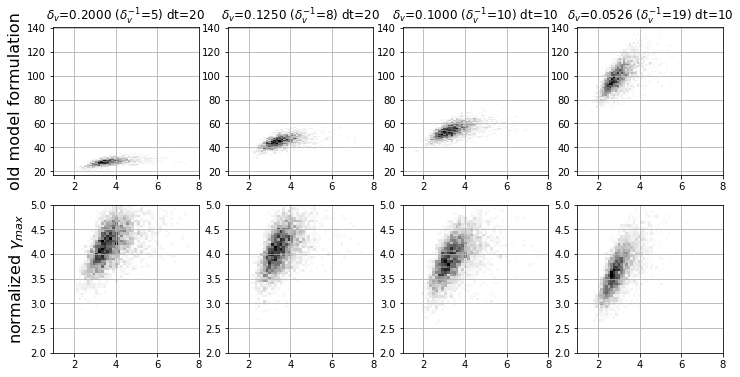

In [26]:
xname = 'delta_max'
yname = 'gamma_max'

desc = {'oldformulation':'old model formulation', 'normparam':'normalized $\gamma_{max}$'}

ncols = len(data)
nrows = len(models)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,12/ncols*nrows))

for irow,name in enumerate(models):
    xlim = np.array((1000,-1))
    ylim = np.array((1000,-1))
    for icol,k in enumerate(data):
        ax = axs[irow,icol]
        ax.hist2d(mcmc[name][k][xname],mcmc[name][k][yname],bins=50,cmap=mpl.cm.gray_r)
        ax.grid(True)
        
        cxlim = ax.get_xlim()
        cylim = ax.get_ylim()
        
        xlim[0] = min(xlim[0], cxlim[0])
        xlim[1] = max(xlim[1], cxlim[1])
        ylim[0] = min(ylim[0], cylim[0])
        ylim[1] = max(ylim[1], cylim[1])
        
        if icol == 0:
            ax.set_ylabel(desc[name], size=16)
        if irow == 0:
            ax.set_title('$\delta_v$={:.4f} ($\delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
    for ax in axs[irow,:]:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)


In [34]:
sig_quantiles = {}

for name in models:
    sig_quantiles[name] = {}
    for k in data:
        m = data[k]['m']
        v_min = data_seaflow[k]['v_min']
        delta_v = 1.0/data_seaflow[k]['delta_v_inv']
        v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v) 
        num_samples = mcmc[name][k]['sig_offset'].shape[0]
        tmp = np.full((num_samples,m), fill_value=np.nan)
        for i in range(num_samples):
            tmp[i,:] = mcmc[name][k]['delta_max'][i]/(1.0+np.exp(-mcmc[name][k]['sig_steepness'][i]*(v-mcmc[name][k]['sig_offset'][i])))

        sig_quantiles[name][k] = np.percentile(tmp, q=(5,25,50,75,95), axis=0)

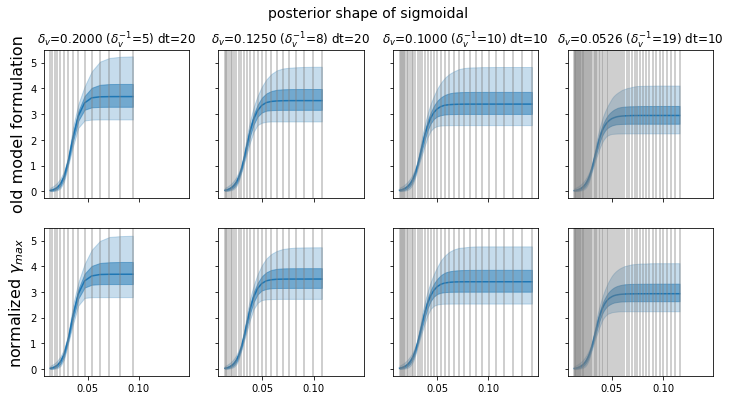

In [45]:
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12,12/ncols*nrows))

for irow,name in enumerate(models):
    for icol,k in enumerate(data):
        v_min = data_seaflow[k]['v_min']
        delta_v = 1.0/data_seaflow[k]['delta_v_inv']
        v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v)
        
        ax = axs[irow,icol]
        ax.fill_between(x=v, y1=sig_quantiles[name][k][0,:], y2=sig_quantiles[name][k][-1,:], alpha=0.25, color='C0')
        ax.fill_between(x=v, y1=sig_quantiles[name][k][1,:], y2=sig_quantiles[name][k][-2,:], alpha=0.5, color='C0')
        ax.plot(v, sig_quantiles[name][k][2,:], color='C0')
        
        if icol == 0:
            ax.set_ylabel(desc[name], size=16)
        if irow == 0:
            ax.set_title('$\delta_v$={:.4f} ($\delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
        for vi in v:
            ax.axvline(vi, color='.5', alpha=0.5)
fig.suptitle('posterior shape of sigmoidal', size=14)
None

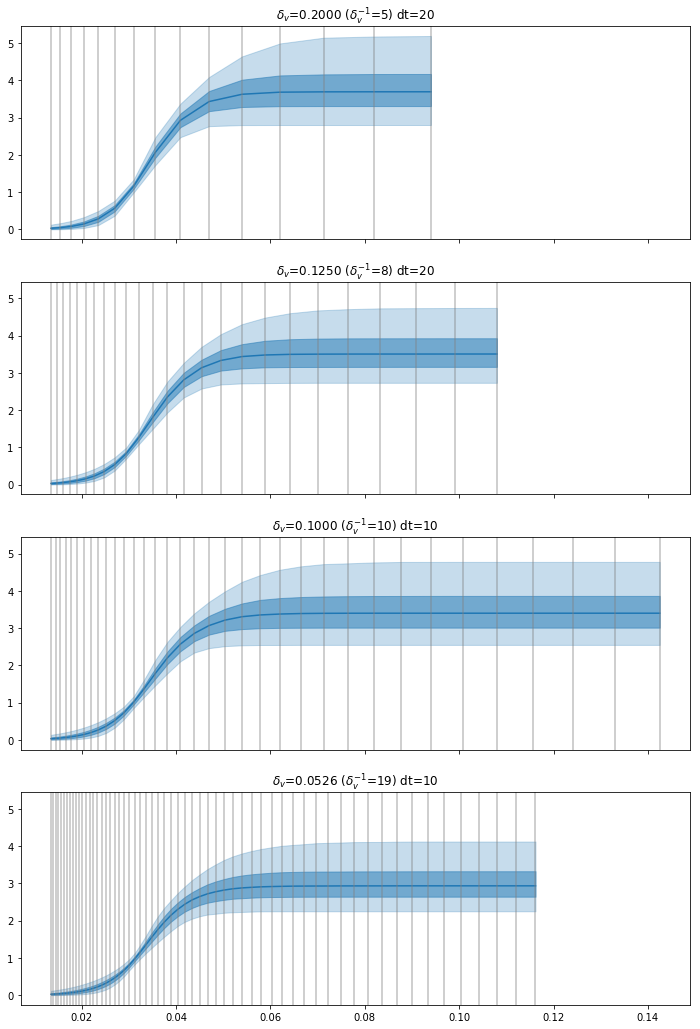

In [50]:
name = 'normparam'

fig, axs = plt.subplots(nrows=len(sig_quantiles[name]), sharex=True, sharey=True, figsize=(12,18))
for iax,k in enumerate(data):
    v_min = data_seaflow[k]['v_min']
    delta_v = 1.0/data_seaflow[k]['delta_v_inv']
    v = v_min * 2**(np.arange(data_seaflow[k]['m'])*delta_v)

    ax = axs[iax]
    ax.fill_between(x=v, y1=sig_quantiles[name][k][0,:], y2=sig_quantiles[name][k][-1,:], alpha=0.25, color='C0')
    ax.fill_between(x=v, y1=sig_quantiles[name][k][1,:], y2=sig_quantiles[name][k][-2,:], alpha=0.5, color='C0')
    ax.plot(v, sig_quantiles[name][k][2,:], color='C0')
    
    ax.set_title('$\delta_v$={:.4f} ($\delta_v^{{-1}}$={:.0f}) dt={:d}'.format(1/data[k]['delta_v_inv'],
                                                                               data[k]['delta_v_inv'],
                                                                               data[k]['dt']))
    for vi in v:
        ax.axvline(vi, color='.5', alpha=0.5)